In [1]:
#dependencies
! python -m pip install nltk
! python -m pip install wordcloud
! python -m pip install Unidecode
! python -m pip install beautifulsoup4

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
from dpm_preprocessing import DPMProprocessed
import torch
#from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments, RobertaConfig
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import f1_score

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

model_name = "microsoft/deberta-v2-xlarge"
assert model_name in ['roberta-base', 'bert-base-uncased', 'google/electra-small-discriminator', "microsoft/deberta-v2-xlarge"]

model_path = f'./models/pcl_{model_name}_finetuned/model/'
tokenizer_path = f'./models/pcl_{model_name}_finetuned/tokenizer/'
MAX_SEQ_LEN = 256

WORKING_ENV = 'SERVER' # Can be JONAS, SERVER
assert WORKING_ENV in ['JONAS', 'SERVER']

if WORKING_ENV == 'SERVER':
    temp_model_path = f'/hy-tmp/pcl/{model_name}/'
if WORKING_ENV == 'JONAS': 
    temp_model_path = f'./experiment/pcl/{model_name}/'

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Looking in indexes: https://mirrors.aliyun.com/pypi/simple


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
class PCLDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set):

        self.tokenizer = tokenizer
        self.texts = list(input_set['text'])
        self.labels = list(input_set['label'])
        
    def collate_fn(self, batch):

        texts = []
        labels = []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=MAX_SEQ_LEN)
        encodings['labels'] =  torch.tensor(labels)
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        item = {'text': self.texts[idx],
                'label': self.labels[idx]}
        return item

In [4]:
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name , config = config).to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v2-xlarge were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaV2ForSequenceClassification 

In [5]:
dpm_pp = DPMProprocessed('.', 'task4_test.tsv')


df_type = 'UNBALANCED' # Can be UNBALANCED, BACKTRANS, OVERSAMPLING
assert df_type in ['UNBALANCED', 'BACKTRANS', 'OVERSAMPLING']

if df_type == 'UNBALANCED':
    train_df_path = 'traindf.pickle'
    val_df_path = 'valdf.pickle'
if df_type == 'BACKTRANS': 
    train_df_path = 'traindf_backtrans.pickle'
    val_df_path = 'valdf_backtrans.pickle'


if not os.path.isfile(train_df_path) or not os.path.isfile(val_df_path):
  train_df, val_df = dpm_pp.get_unbalanced_split(0.1)
  train_df.to_pickle('traindf.pickle')
  val_df.to_pickle('valdf.pickle')
else:
  train_df = pd.read_pickle(train_df_path)
  val_df = pd.read_pickle(val_df_path)

print("Training set length: ",len(train_df))
print("Validation set length: ",len(val_df))

train_dataset = PCLDataset(tokenizer, train_df)
eval_dataset = PCLDataset(tokenizer, val_df)


Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}
      par_id      art_id     keyword country  \
0          1  @@24942188    hopeless      ph   
1          2  @@21968160     migrant      gh   
2          3  @@16584954   immigrant      ie   
3          4   @@7811231    disabled      nz   
4          5   @@1494111     refugee      ca   
...      ...         ...         ...     ...   
10464  10465  @@14297363       women      lk   
10465  10466  @@70091353  vulnerable      ph   
10466  10467  @@20282330     in-need      ng   
10467  10468  @@16753236    hopeless      in   
10468  10469  @@16779383    homeless      ie   

                                                    text  label orig_label  \
0      We are living in times of absolute insanity , ...      0          0   
1      In Libya today , there are countless number of...      0         

In [6]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.logits
        # weight_scale = len(train_df[train_df['label']==0])/len(train_df[train_df['label']==1])
        weight_scale = 1
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, weight_scale]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return ((loss, outputs) if return_outputs else loss)

In [7]:
validation_loader = DataLoader(eval_dataset)
def compute_metric_eval(arg):
    logits, labels_gold = arg[0], arg[1]
    labels_pred = np.argmax(logits, axis = 1)
    return {'f1_macro' :f1_score(labels_gold, labels_pred, average='macro'), 
            'pcl_f1': classification_report(labels_gold, labels_pred, target_names=["Not PCL","PCL"], output_dict= True)['PCL']['f1-score']} #more metrics can be added

training_args = TrainingArguments(
        output_dir=temp_model_path,
        learning_rate = 1e-6,
        logging_steps= 100,
        eval_steps = 500,
        per_device_train_batch_size=4,
        per_device_eval_batch_size = 4,
        num_train_epochs = 4,
        evaluation_strategy= "steps",
        load_best_model_at_end=True,
        metric_for_best_model='pcl_f1'
        )

trainer = CustomTrainer(
        model=model,                         
        args=training_args,                 
        train_dataset=train_dataset,                   
        data_collator=eval_dataset.collate_fn,
        compute_metrics = compute_metric_eval,
        eval_dataset = eval_dataset
    )
trainer.train()

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9422
  Num Epochs = 4
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 9424


Step,Training Loss,Validation Loss,F1 Macro,Pcl F1
500,0.453900,0.488882,0.475188,0.000000
1000,0.423500,0.390659,0.475188,0.000000
1500,0.341300,0.345728,0.609677,0.264463
2000,0.355800,0.322935,0.681084,0.402985
2500,0.358900,0.352524,0.722139,0.482759
3000,0.306300,0.342364,0.748465,0.538012
3500,0.317800,0.321558,0.739493,0.516556
4000,0.327600,0.340478,0.714841,0.468085
4500,0.450000,0.314339,0.752659,0.541935
5000,0.267900,0.346711,0.789387,0.615385


***** Running Evaluation *****
  Num examples = 1047
  Batch size = 4
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

TrainOutput(global_step=9424, training_loss=0.2959647667175238, metrics={'train_runtime': 4043.662, 'train_samples_per_second': 9.32, 'train_steps_per_second': 2.331, 'total_flos': 1.2884359771641792e+16, 'train_loss': 0.2959647667175238, 'epoch': 4.0})

In [8]:
trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)

train_df.to_pickle('train_df.pickle')
val_df.to_pickle('val_df.pickle')

Saving model checkpoint to ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/model/
Configuration saved in ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/model/config.json
Model weights saved in ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/model/pytorch_model.bin
tokenizer config file saved in ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/tokenizer/tokenizer_config.json
Special tokens file saved in ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/tokenizer/special_tokens_map.json
added tokens file saved in ./models/pcl_microsoft/deberta-v2-xlarge_finetuned/tokenizer/added_tokens.json


In [9]:
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path , config = config).to(device)


loading configuration file https://huggingface.co/microsoft/deberta-v2-xlarge/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/9b1521087cc24b2b8011f3a1ed13d4adfedc3c0668198e49f5cd0fbac08c1390.68c59ec99ca9b4a368c8bc9f42e06b33f4766cb50174c88e8000ed1880fa4d3a
Model config DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v2-xlarge",
  "attention_head_size": 64,
  "attention_probs_dropout_prob": 0.1,
  "conv_act": "gelu",
  "conv_kernel_size": 3,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 6144,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 24,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 1536,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_inp

In [10]:

train_df = pd.read_pickle('train_df.pickle')
val_df = pd.read_pickle('val_df.pickle')

train_dataset = PCLDataset(tokenizer, train_df)
eval_dataset = PCLDataset(tokenizer, val_df)

In [11]:
def predict_pcl(input, tokenizer, model, threshold=0.5):
    model.eval()
    encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=256)
    encodings = encodings.to(device)
    output = model(**encodings)
    logits = output.logits
    prob = nn.functional.softmax(logits)[: , 1].cpu()
    preds = np.array([int(prob>threshold)])
    return {'prediction': preds, 'confidence': prob}


def evaluate(model, tokenizer, data_loader, threshold=0.5):
    preds = []
    tot_labels = []
    confidences = []
    with torch.no_grad():
        for data in (data_loader):
            labels = {}
            labels['label'] = data['label']

            tweets = data['text']

            pred = predict_pcl(tweets, tokenizer, model, threshold)

            preds.append(np.array(pred['prediction']))
            tot_labels.append(np.array(labels['label'].cpu()))
            confidences.append(np.array(pred['confidence'].cpu()))

    # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score

    return preds, tot_labels, confidences

In [12]:
validation_loader = DataLoader(eval_dataset)

preds, tot_labels, confidences = evaluate(model, tokenizer, validation_loader)
tot_labels = np.array(tot_labels)
preds = np.array(preds)
confidences = np.array(confidences)
report = classification_report(tot_labels, preds, target_names=["Not PCL", "PCL"], output_dict=True)
print(report)

print(report['accuracy'])
print(report['Not PCL']['f1-score'])
print(report['PCL']['f1-score'])

/tmp/ipykernel_760/1932561778.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = nn.functional.softmax(logits)[: , 1].cpu()


{'Not PCL': {'precision': 0.9557157569515963, 'recall': 0.9789029535864979, 'f1-score': 0.9671704012506515, 'support': 948}, 'PCL': {'precision': 0.7368421052631579, 'recall': 0.5656565656565656, 'f1-score': 0.64, 'support': 99}, 'accuracy': 0.9398280802292264, 'macro avg': {'precision': 0.8462789311073771, 'recall': 0.7722797596215318, 'f1-score': 0.8035852006253257, 'support': 1047}, 'weighted avg': {'precision': 0.9350199675369302, 'recall': 0.9398280802292264, 'f1-score': 0.9362345180378392, 'support': 1047}}
0.9398280802292264
0.9671704012506515
0.64


In [13]:
confidences

array([[1.1940618e-03],
       [4.1436334e-04],
       [3.1022815e-04],
       ...,
       [3.2770116e-04],
       [8.5414242e-05],
       [3.8479487e-04]], dtype=float32)

In [14]:
# define threshold
pcl_count_by_threshold = []
non_pcl_count_by_threshold = []
f1_by_threshold = []
for percentage in range(100):
    threshold = percentage / 100
    pcl_count = (confidences > threshold).sum()
    non_pcl_count = (confidences <= threshold).sum()
    pred = np.zeros(tot_labels.shape)
    pred[confidences > threshold] = 1
    pcl_count_by_threshold.append(pcl_count)
    non_pcl_count_by_threshold.append(non_pcl_count)
    f1_by_threshold.append(classification_report(tot_labels, pred, target_names=["Not PCL", "PCL"], output_dict=True)['PCL']['f1-score'])

best_threshold = np.argmax(f1_by_threshold) / 100

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# best_threshold
np.max(f1_by_threshold)

0.6408839779005524

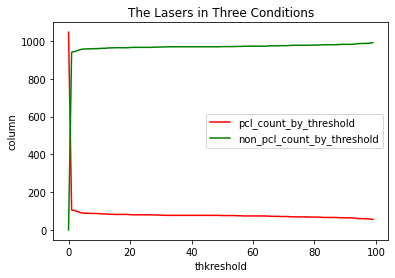

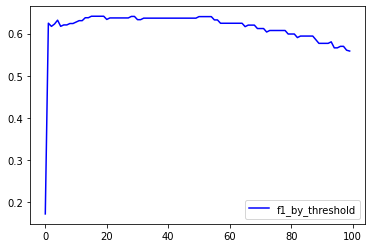

In [16]:
import matplotlib.pyplot as plt

x=np.arange(0,100)
l1=plt.plot(x,pcl_count_by_threshold,'r',label='pcl_count_by_threshold')
l2=plt.plot(x,non_pcl_count_by_threshold,'g',label='non_pcl_count_by_threshold')

# plt.plot(x1,y1,'ro-',x2,y2,'g+-',x3,y3,'b^-')
plt.title('The Lasers in Three Conditions')
plt.xlabel('thkreshold')
plt.ylabel('column')
plt.legend()
plt.show()

plt.clf()
l3=plt.plot(x, f1_by_threshold,'b',label='f1_by_threshold')
plt.legend()
plt.show()

# Test set

In [28]:
dpm_pp.load_test()
test_df = dpm_pp.test_set_df
test_df['label'] = 0
test_dataset = PCLDataset(tokenizer, test_df)

test_loader = DataLoader(test_dataset)

preds, tot_labels, confidences = evaluate(model, tokenizer, test_loader, best_threshold)
tot_labels = np.array(tot_labels)
preds = np.array(preds)
# report = classification_report(tot_labels, preds, target_names=["Not PCL","PCL"], output_dict= True)
# print(report)

# print(report['accuracy'])
# print(report['Not PCL']['f1-score'])
# print(report['PCL']['f1-score'])

/tmp/ipykernel_760/1932561778.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = nn.functional.softmax(logits)[: , 1].cpu()


In [24]:
# preds.shape
preds.shape

(3832, 1)

In [25]:
from collections import Counter
preds = preds.reshape(-1)
Counter(preds)

Counter({0: 3579, 1: 253})

In [26]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [27]:
labels2file([[k] for k in preds], 'task1.txt')
!cat task1.txt | head -n 10
!zip submission.zip task1.txt 

0
0
0
0
0
0
0
0
0
0
updating: task1.txt (deflated 95%)
